---
# A novel optimal approach towards classification of skin lesions
---
## Model 1 - **RegNetY032**
---

## Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from PIL import ImageFile

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Extracting the dataset from zip file

In [ ]:
from zipfile import ZipFile
filename="/content/drive/MyDrive/HAM10000.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("Zip extracted.")

Zip extracted.


## Exploratory Data Analysis (EDA)

In [ ]:
data_pd = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [ ]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [ ]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

In [ ]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [ ]:
df_ham = data_pd[data_pd['is_duplicate'] == 'no']

## Functions to count, and plot image-count histograms

In [ ]:
def count_images_in_subfolders(root_folder):
    image_counts = {}

    for foldername, subfolders, filenames in os.walk(root_folder):
        folder_name = os.path.basename(foldername)  # Extract the subfolder name
        for filename in filenames:
            # Check if the file has a common image extension (you can customize this list)
            if filename.lower().endswith('.jpg'):
                image_counts[folder_name] = image_counts.get(folder_name, 0) + 1
    image_counts = dict(sorted(image_counts.items()))
    return image_counts

In [ ]:
def plot_histogram(image_counts, title):
    folders = list(image_counts.keys())
    counts = list(image_counts.values())
    plt.bar(folders, counts, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()

## Train-test split
### Train Data = 80 % | Validation Data = 10 % | Test Data = 10 %

In [ ]:
train_df, temp_df = train_test_split(df_ham, test_size=0.2, stratify=df_ham['dx'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'])

**stratify=df_ham['dx']** ensures that the splitting is done in a way that preserves the proportion of samples for each class label in the column 'dx' (stratified sampling).

In [ ]:
def identify_train_test(x):
    train_data = set(train_df['image_id'])
    val_data = set(val_df['image_id'])
    test_data = set(test_df['image_id'])
    if str(x) in train_data:
        return 'train'
    elif str(x) in val_data:
        return 'val'
    else:
        return 'test'

In [ ]:
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
4749,HAM_0003219,ISIC_0024737,nv,follow_up,50.0,male,lower extremity,no
5141,HAM_0002958,ISIC_0026088,nv,follow_up,45.0,male,neck,no
5048,HAM_0005240,ISIC_0030169,nv,follow_up,65.0,male,abdomen,no
5239,HAM_0004333,ISIC_0032259,nv,follow_up,50.0,male,trunk,no
1460,HAM_0007272,ISIC_0024756,mel,histo,60.0,male,lower extremity,no


In [ ]:
val_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
4763,HAM_0000071,ISIC_0029299,nv,follow_up,55.0,female,back,no
5472,HAM_0004920,ISIC_0030983,nv,follow_up,65.0,male,back,no
9581,HAM_0004210,ISIC_0034081,nv,consensus,40.0,female,unknown,no
5991,HAM_0007458,ISIC_0030266,nv,follow_up,55.0,male,lower extremity,no
696,HAM_0003183,ISIC_0027017,bkl,histo,75.0,male,neck,no


In [ ]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
4316,HAM_0006505,ISIC_0031343,nv,follow_up,45.0,female,abdomen,no
3644,HAM_0005813,ISIC_0026051,nv,follow_up,20.0,male,back,no
6142,HAM_0001760,ISIC_0024389,nv,follow_up,45.0,male,lower extremity,no
2301,HAM_0007031,ISIC_0025616,mel,histo,70.0,female,upper extremity,no
8982,HAM_0001962,ISIC_0029749,nv,histo,75.0,male,lower extremity,no


In [ ]:
# Image id of train and test images
train_list = list(train_df['image_id'])
val_list = list(val_df['image_id'])
test_list = list(test_df['image_id'])

In [ ]:
print('Before Augmentation')
print(f'Number of train images: {len(train_list)}')
print(f'Number of validation images: {len(val_list)}')
print(f'Number of test images: {len(test_list)}')

Before Augmentation
Number of train images: 4411
Number of validation images: 551
Number of test images: 828


In [ ]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

## Organizing the dataset into folders

In [ ]:
base_dir = '/content/HAM10000'

In [ ]:
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')
test_dir = os.path.join(base_dir, 'test_dir')

In [ ]:
os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

In [ ]:
classes = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [ ]:
for c in classes:
    os.mkdir(train_dir + '/' + c)
    os.mkdir(val_dir + '/' + c)
    os.mkdir(test_dir + '/' + c)

In [ ]:
for image in train_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx'].upper()

    # path of source image
    source = os.path.join(base_dir, file_name)

    # moving the image from the source to target directory
    target = os.path.join(train_dir, label, file_name)

    shutil.move(source, target)

In [ ]:
for image in val_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx'].upper()

    # path of source image
    source = os.path.join(base_dir, file_name)

    # moving the image from the source to target directory
    target = os.path.join(val_dir, label, file_name)

    shutil.move(source, target)

In [ ]:
for image in test_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx'].upper()

    # path of source image
    source = os.path.join(base_dir, file_name)

    # moving the image from the source to target directory
    target = os.path.join(test_dir, label, file_name)

    shutil.move(source, target)

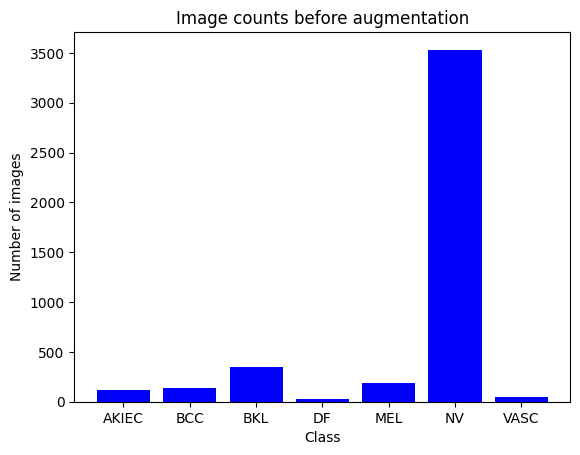

In [ ]:
root_folder = "/content/HAM10000/train_dir"
image_counts = count_images_in_subfolders(root_folder)
plot_histogram(image_counts, "Image counts before augmentation")

In [ ]:
classes = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Augmenting images and storing them in temporary directories
for img_class in classes:

    #creating temporary directories
    # creating a base directory
    aug_dir = '/content/HAM10000/aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('/content/HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('/content/HAM10000/train_dir/' + img_class, file_name)

        # creating a target directory to send images
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = '/content/HAM10000/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        brightness_range=[0.5, 1.5],
        zoom_range=0.3,
        fill_mode='nearest'
    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory
    shutil.rmtree('/content/HAM10000/aug_dir')

Found 121 images belonging to 1 classes.
Found 140 images belonging to 1 classes.
Found 352 images belonging to 1 classes.
Found 31 images belonging to 1 classes.
Found 184 images belonging to 1 classes.
Found 3532 images belonging to 1 classes.
Found 51 images belonging to 1 classes.


In [ ]:
base_dir = '/content/HAM10000'
train_path = os.path.join(base_dir, 'train_dir')
val_path = os.path.join(base_dir, 'val_dir')
test_path = os.path.join(base_dir, 'test_dir')
batch_size=16

In [ ]:
datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.regnet.preprocess_input)

In [ ]:
image_size = 224

In [ ]:
print("Train Images: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

Train Images: 
Found 45668 images belonging to 7 classes.


In [ ]:
print("Validation Images: ")
val_batches = datagen.flow_from_directory(directory=val_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)

Validation Images: 
Found 551 images belonging to 7 classes.


In [ ]:
print("Test Images: ")
test_batches = datagen.flow_from_directory(directory=test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)

Test Images: 
Found 828 images belonging to 7 classes.


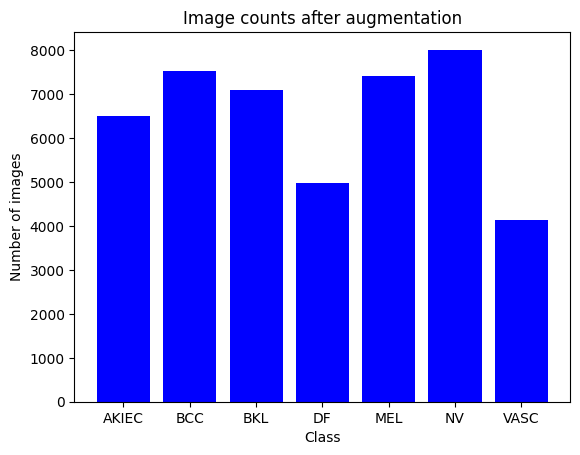

In [ ]:
root_folder = "/content/HAM10000/train_dir"
image_counts = count_images_in_subfolders(root_folder)
plot_histogram(image_counts, "Image counts after augmentation")

## Model creation

In [ ]:
regnet = tf.keras.applications.regnet.RegNetY032(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = regnet.layers[-3].output

In [ ]:
# Modifying the original head of RegNetY032
output = GlobalAveragePooling2D()(conv)
output = Dense(512, activation='relu')(output)
output = Dropout(0.5)(output)
output = Dense(7, activation='softmax')(output)

In [ ]:
model = Model(inputs=regnet.input, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 regnety032_prestem_rescali  (None, 224, 224, 3)          0         ['input_1[0][0]']             
 ng (Rescaling)                                                                                   
                                                                                                  
 regnety032_stem_conv (Conv  (None, 112, 112, 32)         864       ['regnety032_prestem_rescaling
 2D)                                                                [0][0]']                      
                                                                                              

In [ ]:
opt1 = tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Model Checkpoints definition

In [ ]:
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/regnety032.hdf5',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             save_weights_only = True)

## Defining the Early Stopping criteria

In [ ]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=40, min_delta=0.001)

## Model training

In [ ]:
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
                    epochs=100,
                    verbose=2,
                    batch_size=16,
                    validation_data=val_batches,
                    validation_steps=len(test_df)/batch_size,
                    callbacks=[checkpoint, Earlystop])

Epoch 1/100
918/918 - 313s - loss: 1.6490 - accuracy: 0.4992 - val_loss: 1.4520 - val_accuracy: 0.4710 - 313s/epoch - 341ms/step
Epoch 2/100
918/918 - 231s - loss: 1.2509 - accuracy: 0.6196 - val_loss: 1.1189 - val_accuracy: 0.5948 - 231s/epoch - 252ms/step
Epoch 3/100
918/918 - 227s - loss: 1.0686 - accuracy: 0.6783 - val_loss: 0.9987 - val_accuracy: 0.6342 - 227s/epoch - 247ms/step
Epoch 4/100
918/918 - 226s - loss: 0.9409 - accuracy: 0.7193 - val_loss: 0.9236 - val_accuracy: 0.6949 - 226s/epoch - 246ms/step
Epoch 5/100
918/918 - 228s - loss: 0.8389 - accuracy: 0.7502 - val_loss: 0.7874 - val_accuracy: 0.7214 - 228s/epoch - 248ms/step
Epoch 6/100
918/918 - 230s - loss: 0.7645 - accuracy: 0.7711 - val_loss: 0.6898 - val_accuracy: 0.7425 - 230s/epoch - 250ms/step
Epoch 7/100
918/918 - 236s - loss: 0.6939 - accuracy: 0.7949 - val_loss: 0.5741 - val_accuracy: 0.7617 - 236s/epoch - 256ms/step
Epoch 8/100
918/918 - 230s - loss: 0.6468 - accuracy: 0.8109 - val_loss: 0.5874 - val_accuracy: 0

## Epochs vs Accuracy

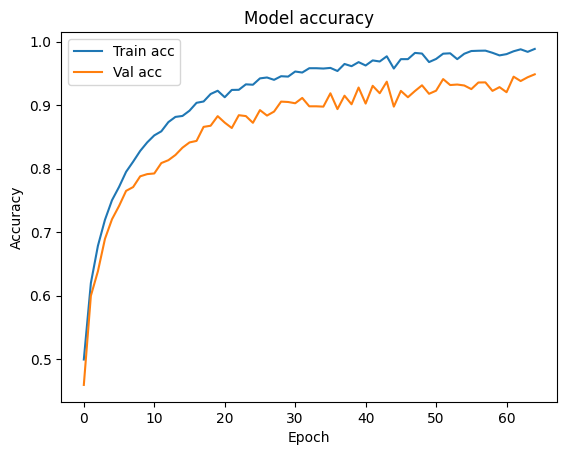

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Val acc'], loc='upper left')
plt.show()

## Epochs vs Loss

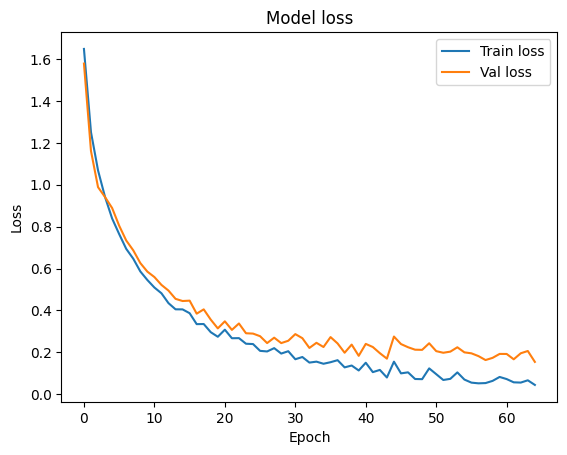

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.show()

## Model Evaluation

In [ ]:
model.load_weights("/content/drive/MyDrive/regnety032.hdf5")

In [ ]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

### 1. Classification Report

In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob=predictions
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames)

print(report)

              precision    recall  f1-score   support

          AK       0.95      0.87      0.91        23
         BCC       0.96      1.00      0.98        26
         BKL       0.93      0.85      0.89        66
          DF       0.86      1.00      0.92         6
         MEL       0.94      0.85      0.89        34
          NV       0.98      1.00      0.99       663
        VASC       1.00      1.00      1.00        10

    accuracy                           0.96       828
   macro avg       0.95      0.94      0.94       828
weighted avg       0.97      0.97      0.97       828


### 2. Confusion Matrix

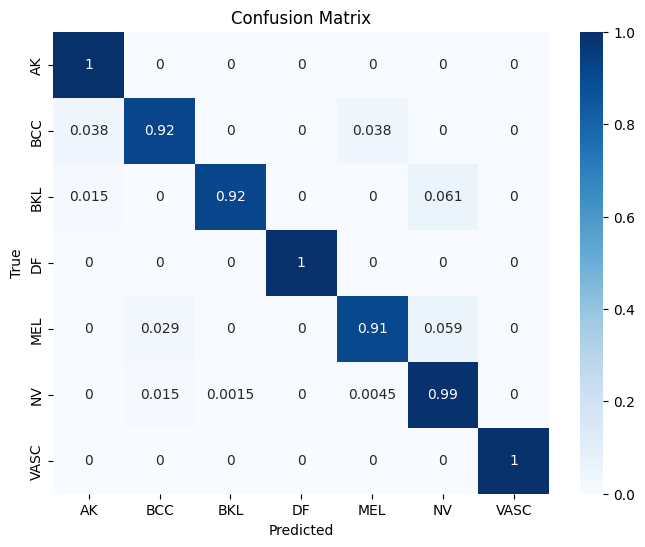

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true')
classes = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
# Plotting the confusion matrix as a blue heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 3. Accuracy, Precision, Recall and F1-Score

In [ ]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')

Accuracy: 0.9638599033816425


In [ ]:
precision = round(precision_score(y_true, y_pred, average='weighted'), 4)
recall = round(recall_score(y_true, y_pred, average='weighted'), 4)
f1_score = round(f1_score(y_true, y_pred, average='weighted'), 4)

In [ ]:
print(f'Precision = {precision}')
print(f'Recall = {recall}')
print(f'F1-Score = {f1_score}')

Precision = 0.9712
Recall = 0.9704
F1-Score = 0.9723


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
print(f'Specificity = {round(specificity, 4)}')

Specificity = 0.9684


### 4. ROC Curves

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of AK is: 1.0
The ROC AUC score of BCC is: 0.9994724726644926
The ROC AUC score of BKL is: 0.9956056629284975
The ROC AUC score of DF is: 1.0
The ROC AUC score of MEL is: 0.9898133056749148
The ROC AUC score of NV is: 0.9962429727135609
The ROC AUC score of VASC is: 1.0


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

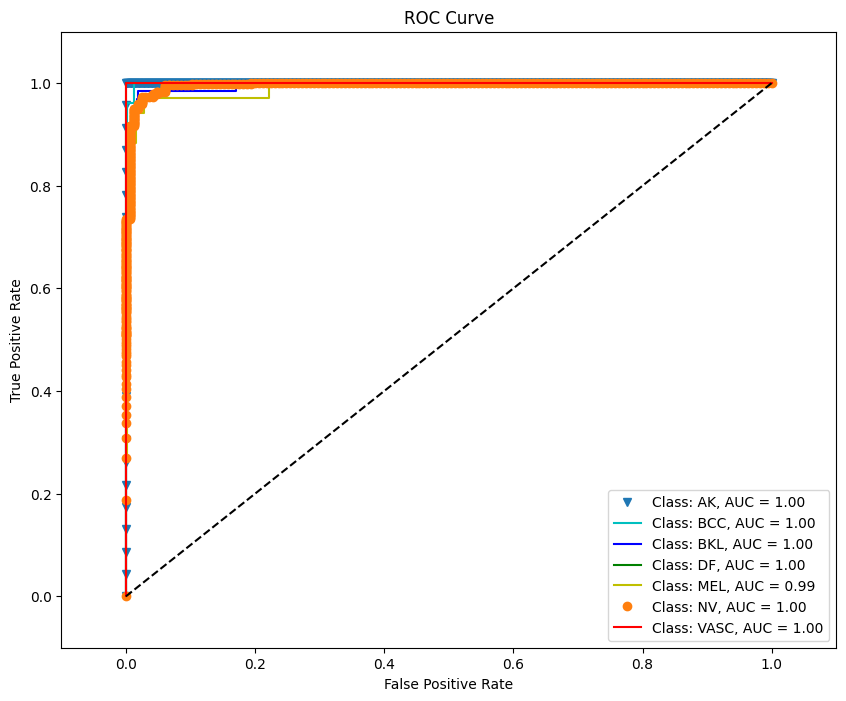

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0],'v',label='Class: AK, AUC = %0.2f' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='Class: BCC, AUC = %0.2f' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='Class: BKL, AUC = %0.2f' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='Class: DF, AUC = %0.2f' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='Class: MEL, AUC = %0.2f' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o',label='Class: NV, AUC = %0.2f' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='Class: VASC, AUC = %0.2f' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

---